In [240]:
import jax
import jax.numpy as jnp
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [234]:
N_ITERATIONS = 3600

In [259]:
@dataclass
class ModelParameters:
    area_outlet: jnp.ndarray
    area_tank: jnp.ndarray
    g: float
    rho: float
    gamma1: float
    gamma2: float

    def __post_init__(self):
        self.flow_rates = jnp.array([
            self.gamma1,
            self.gamma2,
            1 - self.gamma2,
            1 - self.gamma1,
        ])


params = ModelParameters(
    area_outlet=jnp.ones(4) * 1.2272,
    area_tank=jnp.ones(4) * 380.1327,
    g=981,
    rho=1,
    gamma1=0.58,
    gamma2=0.72,
)

In [ ]:
def four_tank_system_undisturbed(state, controls, params):
    # convert mass to height
    tank_heights = jnp.clip(state / (params.area_tank * params.rho), 0, None)
    
    # outflow due to gravity
    outflow = params.area_outlet * jnp.sqrt(2 * params.g * tank_heights)

    # flow from tanks 3 and 4 into tanks 1 and 2
    crossflow = jnp.concatenate((outflow[2:], jnp.zeros(2)))

    # inflow is then pump flow + crossflow
    pump_force = jnp.concatenate((controls, controls[::-1]))    
    inflow = params.flow_rates * pump_force + crossflow

    # change in tank volume equals inflow minus outflow
    xdot = inflow - outflow

    # convert to masses and return
    return xdot * params.rho

In [275]:
def four_tank_system_disturbed(state, controls, disturbance, params):
    xdot = four_tank_system_undisturbed(state, controls, params)
    return xdot + jnp.concatenate((jnp.zeros(2), disturbance))

In [362]:
def sensor_deterministic(state, params):
    return state / params.area_tank

In [239]:
def simulate(
        controller: callable,
        disturbance_model: callable,
        sensor_model: callable,
        params: ModelParameters,
        initial_masses=None, 
        iterations=N_ITERATIONS
    ):
    
    if initial_masses is None:
        initial_masses = jnp.zeros(4)

    states = jnp.empty((iterations + 1, initial_masses.shape[0]))
    observations = jnp.empty((iterations, initial_masses.shape[0]))
    flows = jnp.empty((iterations, initial_masses.shape[0]))

    states[0] = initial_masses

    for t in range(iterations):
        # observe the tank heights
        observation = sensor_model(states[t])#states[t] / params.area_tank
        observations[t] = observation

        # pass into controller
        controls = controller(t, observation)

        # fmin = 0, fmax = 500
        #controls = jnp.clip(controls, 0, 500)

        xdot = four_tank_system_undisturbed(states[t], controls, params)

        # add disturbance
        disturbance = disturbance_model(t, states[t])
        xdot[2:] += disturbance

        # record flows F_1 - F_4
        flows[t, :2] = controls
        flows[t, 2:] = disturbance / params.rho

        states[t + 1] = jnp.clip(states[t] + xdot, 0, np.inf)

    # output the tank heights over time,
    # the inputs (controlled and disturbance),
    # and the observations
    return states[:-1] / params.area_tank, flows, observations


In [202]:
def plot_results(tank_heights, flows, controller, disturbance_model, fig_path=None):

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    upper_bound_top_row = np.max(tank_heights[:,2:]) * 1.2
    upper_bound_low_row = np.max(tank_heights[:,:2]) * 1.2

    fig.suptitle(f"Controls: {controller}, Disturbance: {disturbance_model}")

    ax = axes[1, 1]
    ax.set_title("Tank 1")
    ax.plot(tank_heights[:, 0])
    ax.set_ylim(0, upper_bound_low_row)
    ax.grid(True)

    ax = axes[1, 2]
    ax.set_title("Tank 2")
    ax.plot(tank_heights[:, 1])
    ax.set_ylim(0, upper_bound_low_row)
    ax.grid(True)

    ax = axes[0, 1]
    ax.set_title("Tank 3")
    ax.plot(tank_heights[:, 2])
    ax.set_ylim(0, upper_bound_top_row)
    ax.grid(True)

    ax = axes[0, 2]
    ax.set_title("Tank 4")
    ax.plot(tank_heights[:, 3])
    ax.set_ylim(0, upper_bound_top_row)
    ax.grid(True)

    ax = axes[1, 0]
    ax.set_title("Flow 1 (Controlled)")
    ax.plot(flows[:, 0])
    ax.set_ylim(0, 500)
    ax.grid(True)

    ax = axes[1, 3]
    ax.set_title("Flow 2 (Controlled)")
    ax.plot(flows[:, 1])
    ax.set_ylim(0, 500)
    ax.grid(True)

    ax = axes[0, 0]
    ax.set_title("Flow 3 (Disturbance)")
    ax.plot(flows[:, 2])
    ax.set_ylim(0, 500)
    ax.grid(True)

    ax = axes[0, 3]
    ax.set_title("Flow 4 (Disturbance)")
    ax.plot(flows[:, 3])
    ax.set_ylim(0, 500)
    ax.grid(True)

    plt.tight_layout()

    if fig_path is not None:
        plt.savefig(f"{fig_path}/{controller}_{disturbance_model}.pdf", bbox_inches="tight")

    plt.show()


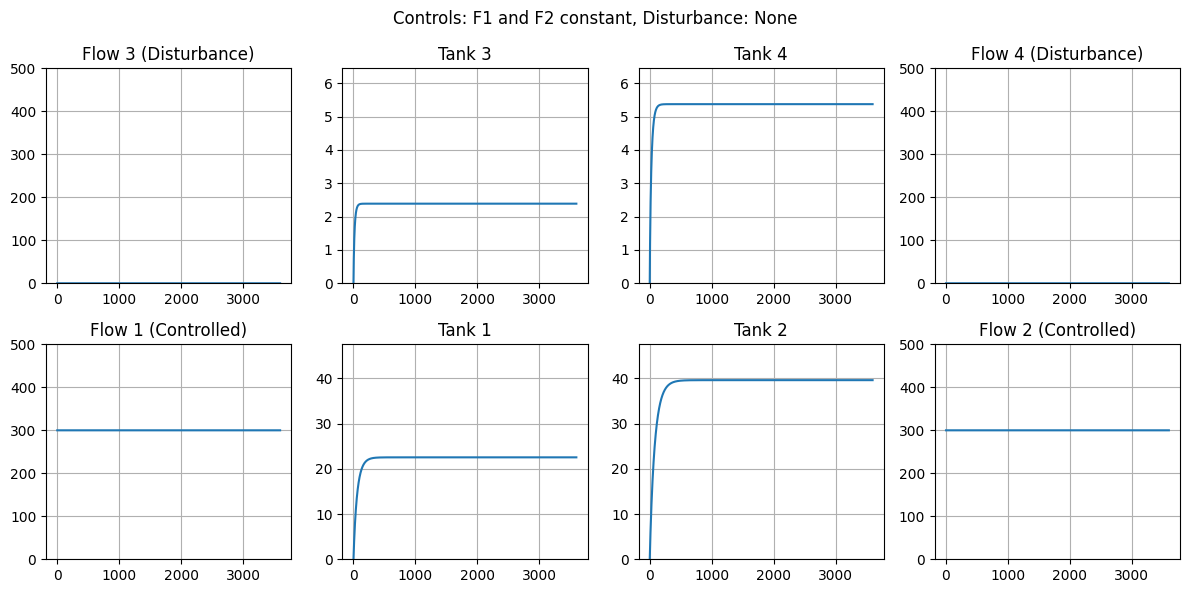

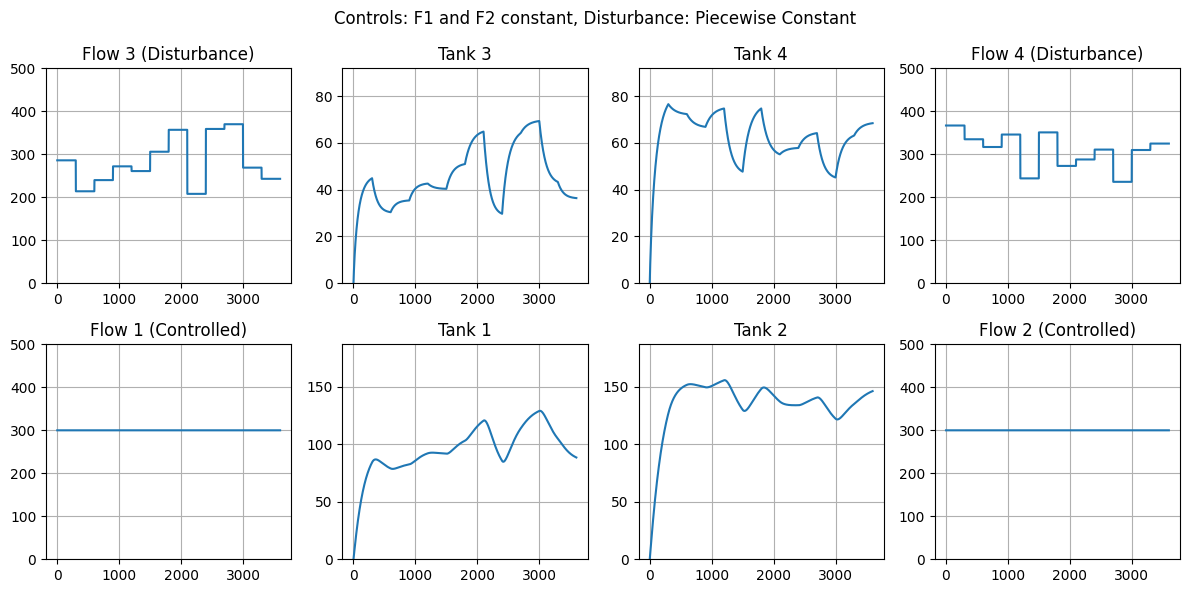

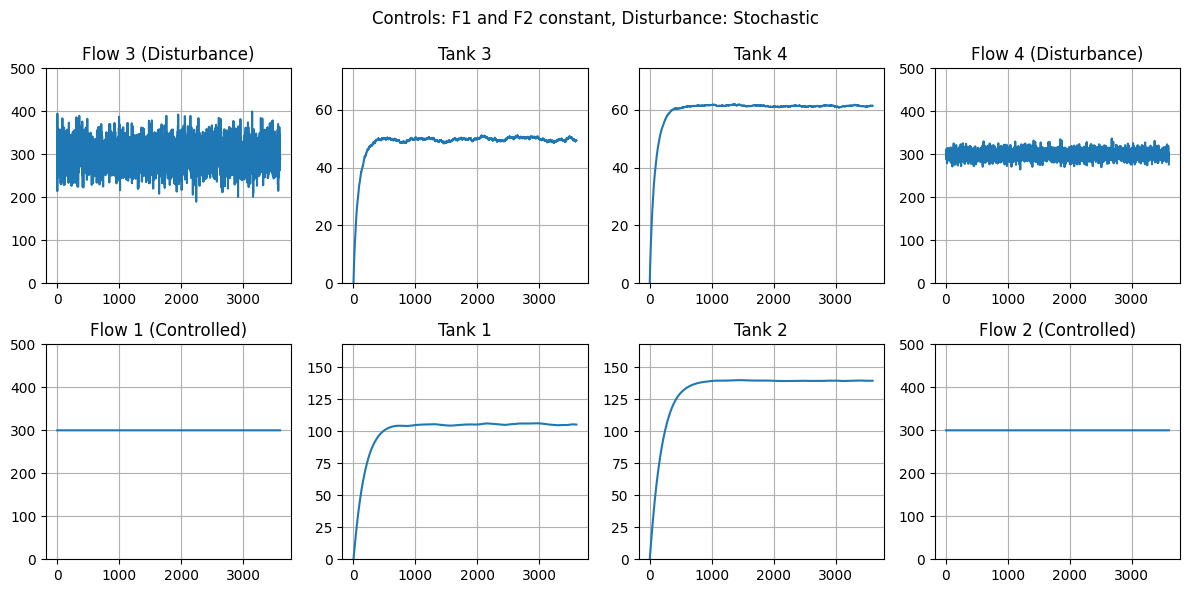

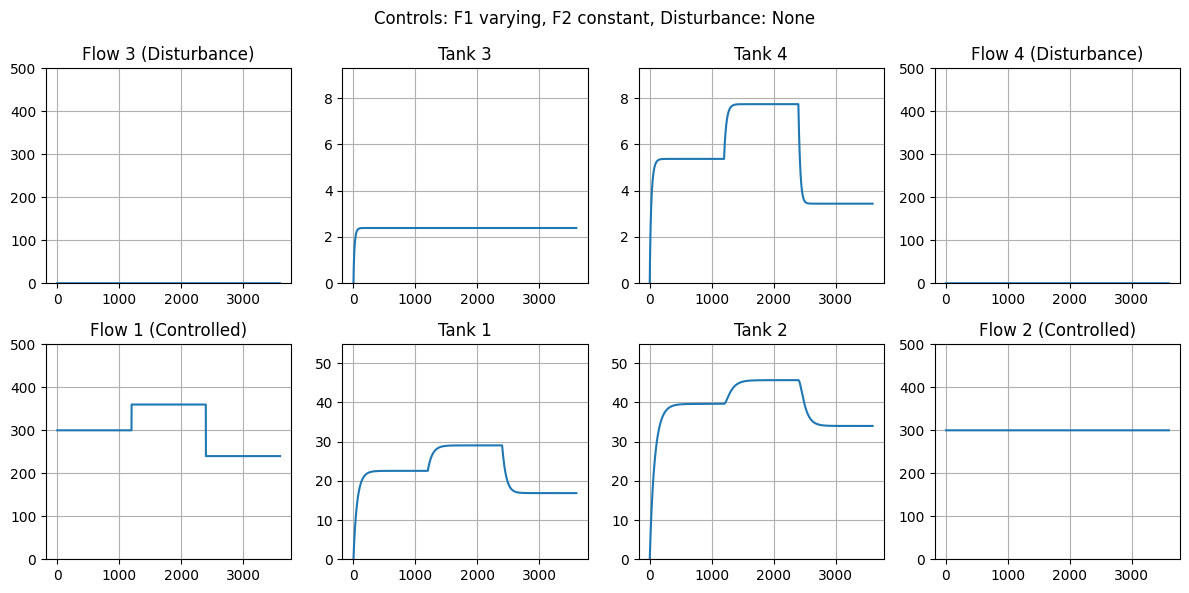

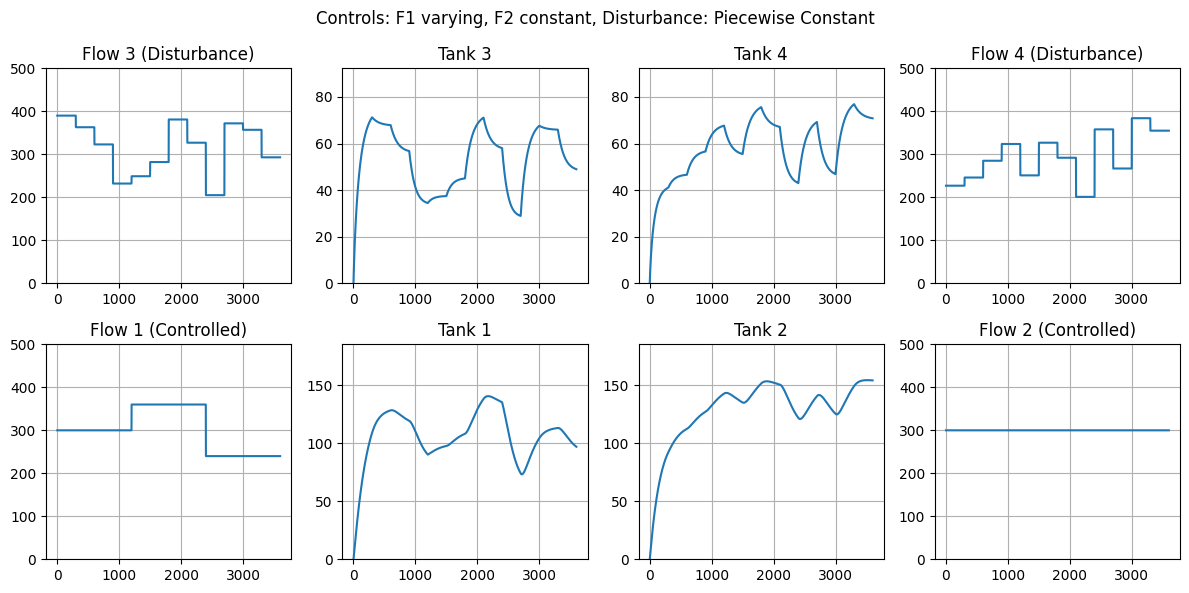

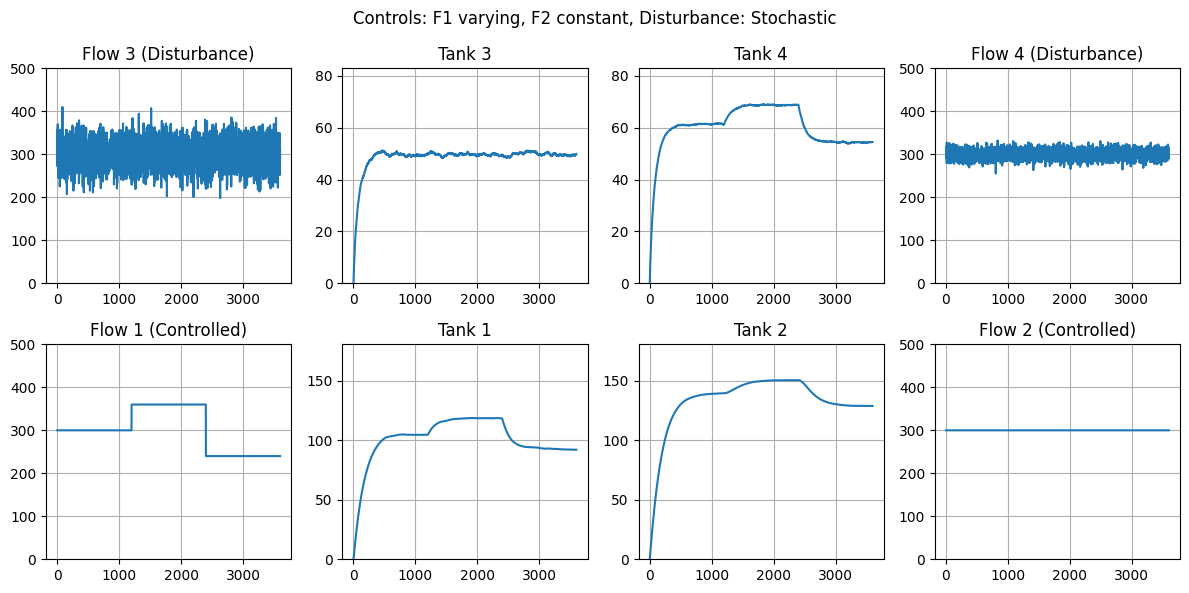

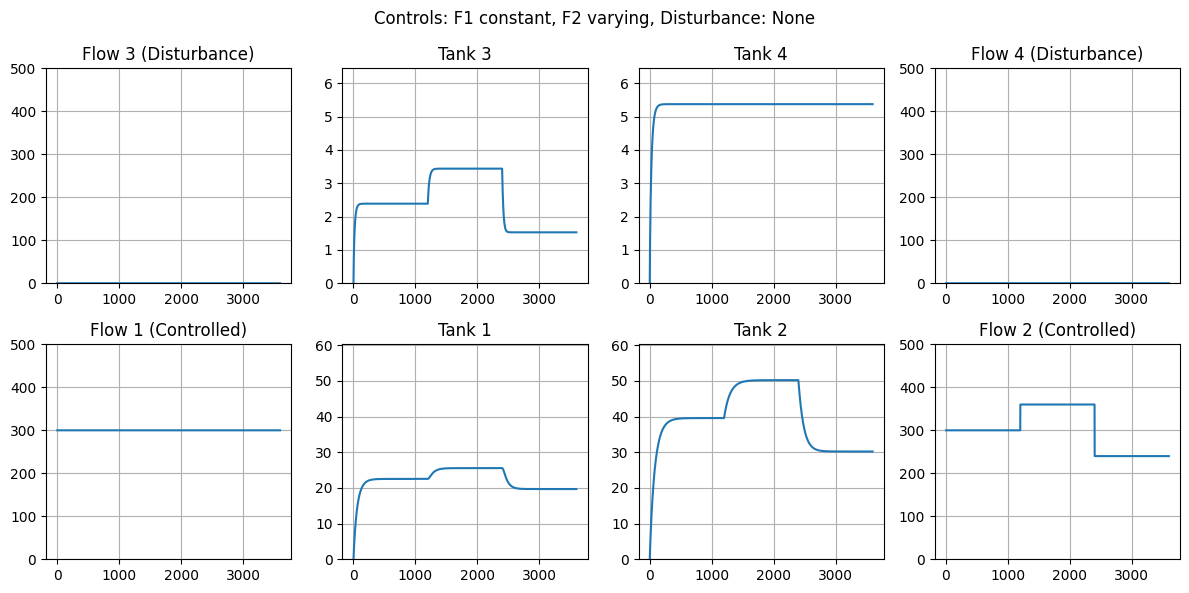

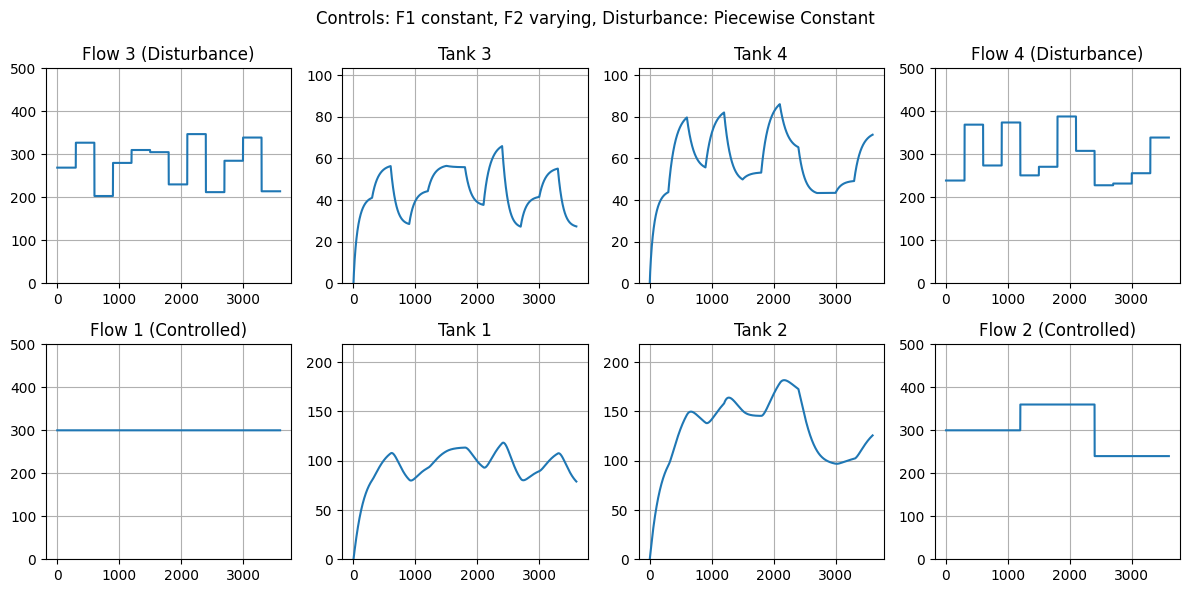

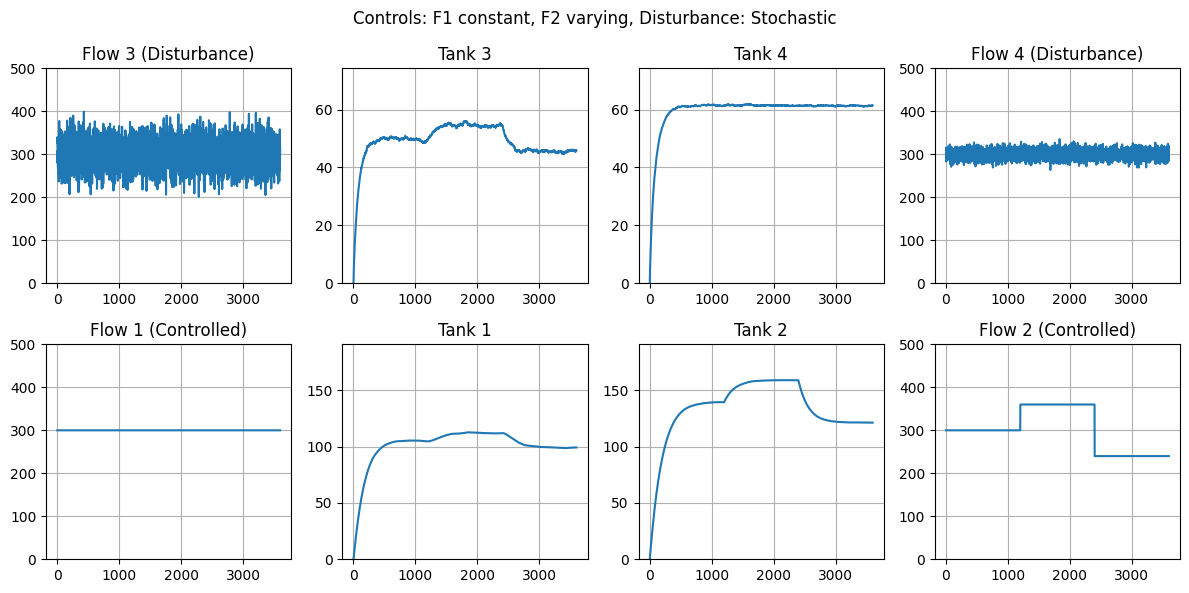

In [ ]:
class Controls1:
    def __init__(self, control=None):
        if control is None:
            self.control = np.ones(2) * 300
        else:
            self.control = control
        
    def __call__(self, t, state):
        return self.control

    def __repr__(self):
        return "F1 and F2 constant"


class Controls2:
    def __init__(self):
        self.u2 = 300

    def __call__(self, t, state):
        if t < 1200:
            u1 = 300
        elif t < 2400:
            u1 = 360
        else:
            u1 = 240
        return np.array([u1, self.u2])

    def __repr__(self):
        return "F1 varying, F2 constant"


class Controls3:
    def __init__(self):
        self.u1 = 300

    def __call__(self, t, state):
        if t < 1200:
            u2 = 300
        elif t < 2400:
            u2 = 360
        else:
            u2 = 240
        return np.array([self.u1, u2])

    def __repr__(self):
        return "F1 constant, F2 varying"


class DisturbanceModel1:
    def __init__(self, disturbance=None):
        if disturbance is None:
            self.disturbance = np.zeros(2)
        else:
            self.disturbance = disturbance

    def __call__(self, t):
        return self.disturbance

    def __repr__(self):
        return "None"


class DisturbanceModel2:
    def __init__(self, n_iterations=N_ITERATIONS, scale=300, low=200, high=400):
        self.scale = scale
        self.dists = np.random.randint(
            low, high, size=(n_iterations // scale, 2)
        )

    def __call__(self, t):
        return self.dists[t // self.scale]

    def __repr__(self):
        return "Piecewise Constant"


class DisturbanceModel3:
    def __init__(self):
        self.mean = np.array([300, 300])
        self.cov = np.array([
            [30**2, 0],
            [0, 10**2],
        ])

    def __call__(self, t):
        return np.random.multivariate_normal(self.mean, self.cov)

    def __repr__(self):
        return "Stochastic"

for controller in (Controls1(), Controls2(), Controls3()):
    for disturbance_model in (DisturbanceModel1(), DisturbanceModel2(), DisturbanceModel3()):
        tank_heights, flows = simulate(
            controller, 
            params, 
            disturbance_model
        )
        plot_results(tank_heights, flows, controller, disturbance_model, fig_path="report/figures/problem2")

In [204]:
class PIDController:
    def __init__(self, target, p=0, i=0, d=0):
        self.target = target
        
        self.p = p
        self.i = i
        self.d = d

        self.prev = None
        self.int = np.zeros(2)

    def __call__(self, t, observation):

        error = self.target - observation[:2]

        p = self.p * error

        self.int += error
        i = self.i * self.int

        if self.prev is not None:
            d = self.d * (error - self.prev)
        else:
            d = np.zeros(2)

        self.prev = error

        return p + i + d
    
    def __repr__(self):
        return f"PID[P={self.p}, I={self.i}, D={self.d}]"

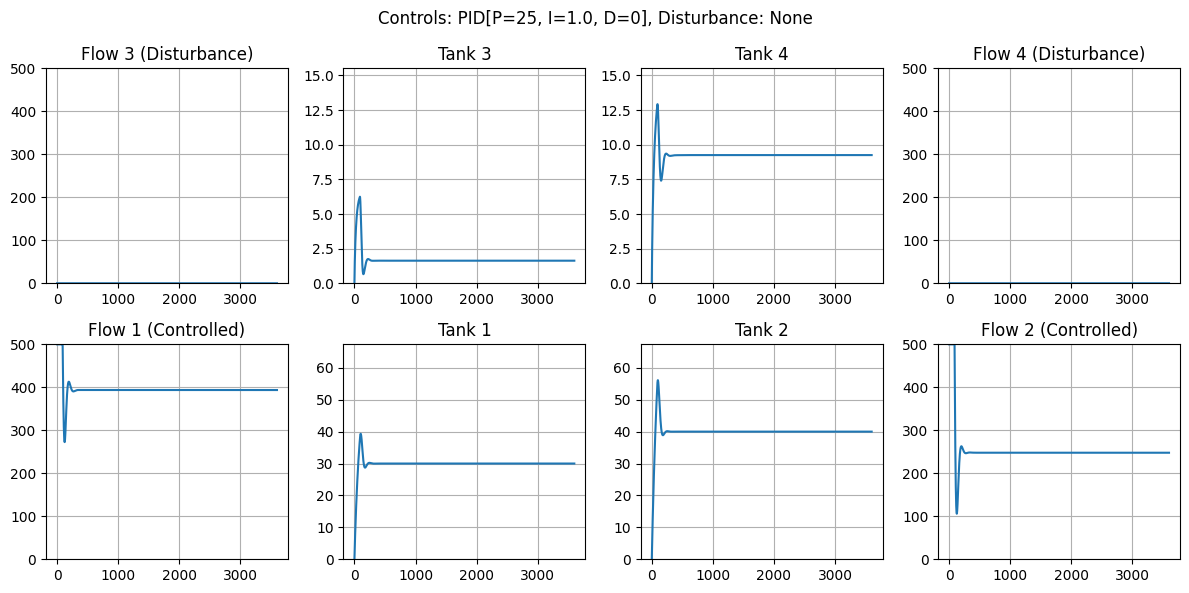

In [205]:
controller = PIDController(np.array([30.0, 40.0]), p=25, i=1.0)

tank_heights, flows = simulate(controller, params, DisturbanceModel1())
plot_results(tank_heights, flows, controller, DisturbanceModel1())

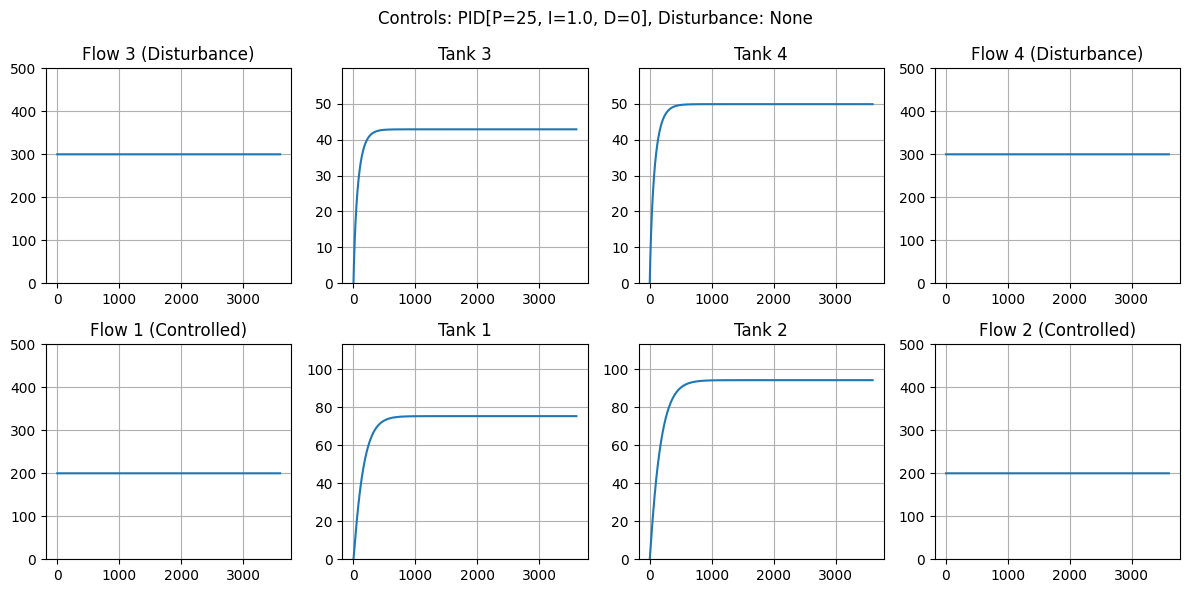

In [216]:
control_steady_state = np.array([200, 200])
disturbance_steady_state = DisturbanceModel1(np.array([300, 300]))

tank_heights, flows = simulate(Controls1(control_steady_state), params, disturbance_steady_state)
plot_results(tank_heights, flows, controller, disturbance_steady_state, fig_path="report/figures/problem4")

In [218]:
heights_steady_state = tank_heights[-1]
mass_steady_state = heights_steady_state * params.area_tank * params.rho

mass_steady_state.round()

array([28661., 35865., 16304., 18970.])

In [208]:
step_sizes = [1.10, 1.25, 1.50]

steps_f1 = np.zeros((3, 2, N_ITERATIONS))

for i, step_size in enumerate(step_sizes):
    controls = Controls1(np.array([200 * step_size, 200]))
    tank_heights, flows = simulate(controls, params, disturbance_steady_state, initial_masses=mass_steady_state)
    steps_f1[i] = tank_heights[:, :2].T


steps_f2 = np.zeros((3, 2, N_ITERATIONS))

for i, step_size in enumerate(step_sizes):
    controls = Controls1(np.array([200, 200 * step_size]))
    tank_heights, flows = simulate(controls, params, disturbance_steady_state, initial_masses=mass_steady_state)
    steps_f2[i] = tank_heights[:, :2].T

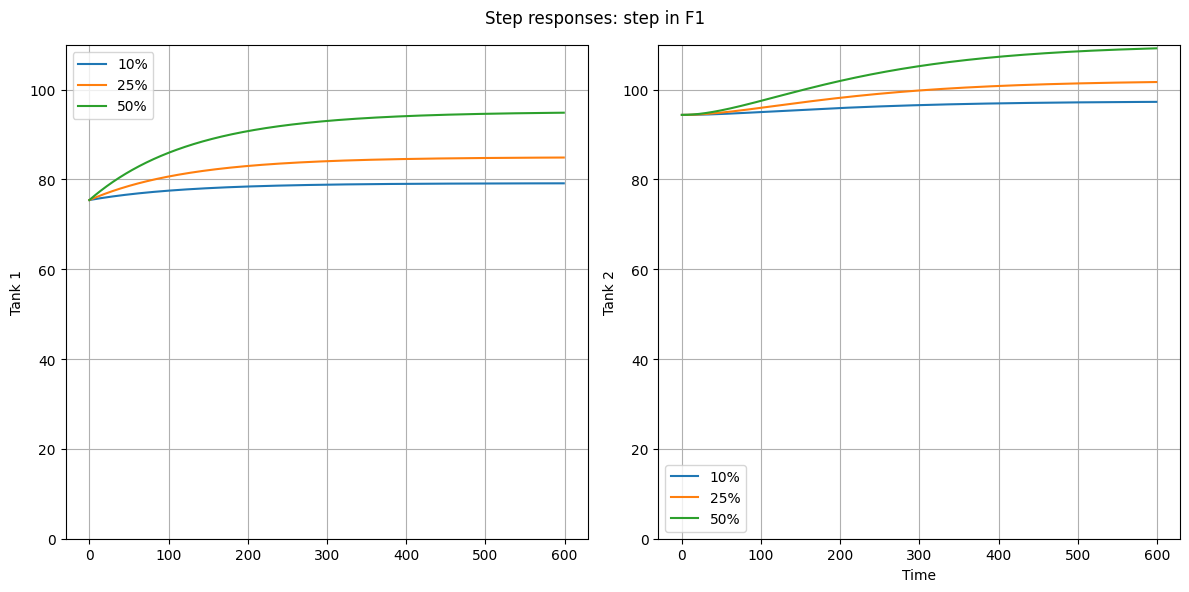

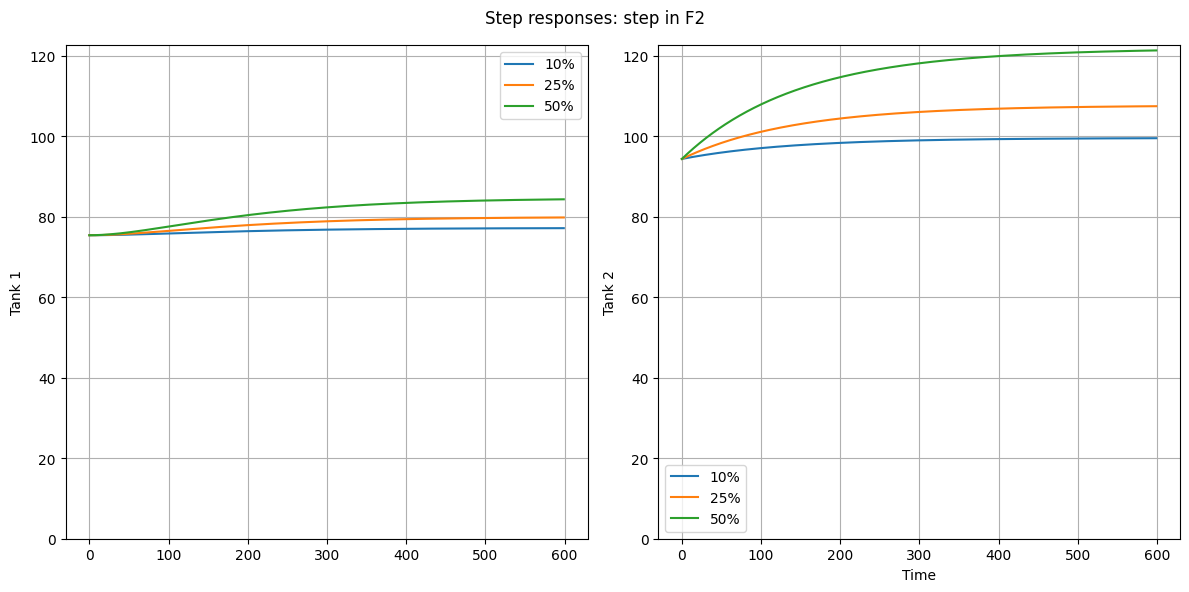

In [209]:
step_labels = ["10%", "25%", "50%"]
tank_labels = ["Tank 1", "Tank 2"]

time = np.arange(steps_f1.shape[2])  # or use real time vector

end_idx = 600

def plot_steps_subplots(steps, title):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

    for i_tank, ax in enumerate(axes):
        for i_step, step_label in enumerate(step_labels):
            ax.plot(
                time[:end_idx],
                steps[i_step, i_tank, :end_idx],
                label=step_label
            )
        ax.set_ylabel(tank_labels[i_tank])
        ax.grid(True)
        ax.legend()

    max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

    axes[0].set_ylim(0, max_ylim)
    axes[1].set_ylim(0, max_ylim)

    axes[-1].set_xlabel("Time")
    fig.suptitle(title)
    fig.tight_layout()

# Step in F1
plot_steps_subplots(steps_f1, "Step responses: step in F1")

# Step in F2
plot_steps_subplots(steps_f2, "Step responses: step in F2")

plt.show()

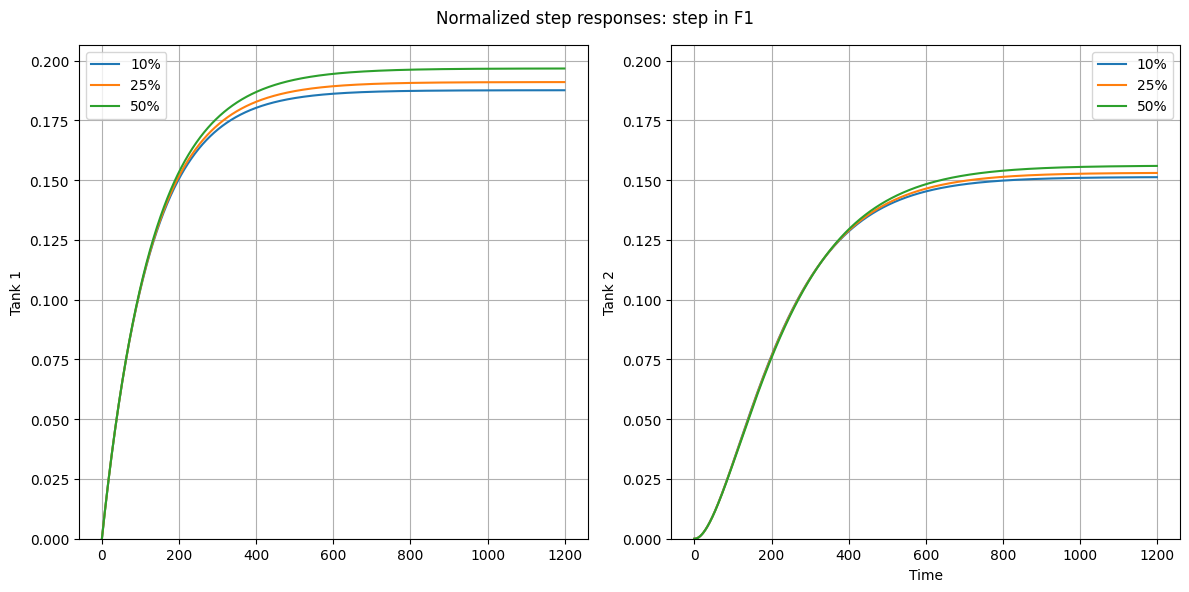

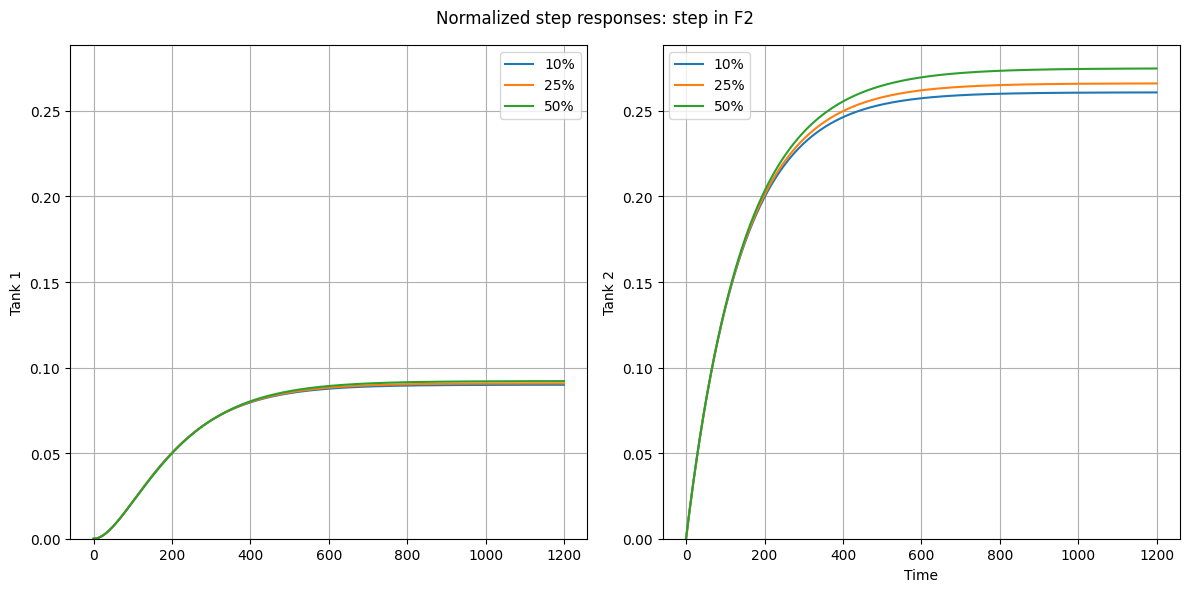

In [220]:
step_labels = ["10%", "25%", "50%"]
tank_labels = ["Tank 1", "Tank 2"]


time = np.arange(steps_f1.shape[2])  # or use real time vector

end_idx = 1200

def plot_steps_subplots(steps, title):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

    for i_tank, ax in enumerate(axes):
        for i_step, step_label in enumerate(step_labels):
            ax.plot(
                time[:end_idx],
                (steps[i_step, i_tank, :end_idx] - steps[i_step, i_tank, 0]) / (200 * step_sizes[i_step] - 200),
                label=step_label
            )
        ax.set_ylabel(tank_labels[i_tank])
        ax.grid(True)
        ax.legend()

    max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

    axes[0].set_ylim(0, max_ylim)
    axes[1].set_ylim(0, max_ylim)

    axes[-1].set_xlabel("Time")
    fig.suptitle(title)
    fig.tight_layout()

# Step in F1
plot_steps_subplots(steps_f1, "Normalized step responses: step in F1")

plt.savefig("report/figures/problem4/normalized_step_deterministic_f1.pdf", bbox_inches="tight")
plt.show()

# Step in F2
plot_steps_subplots(steps_f2, "Normalized step responses: step in F2")

plt.savefig("report/figures/problem4/normalized_step_deterministic_f2.pdf", bbox_inches="tight")
plt.show()

In [211]:
n_trials = 50
n_iterations = 1200
steps_f1_stochastic = np.zeros((3, n_trials, 2, n_iterations))

for i, step_size in enumerate(step_sizes):
    controls = Controls1(np.array([200 * step_size, 200]))
    for n in range(n_trials):
        tank_heights, flows = simulate(controls, params, DisturbanceModel3(), initial_masses=mass_steady_state, iterations=n_iterations)
        steps_f1_stochastic[i, n] = tank_heights[:, :2].T

steps_f2_stochastic = np.zeros((3, n_trials, 2, n_iterations))

for i, step_size in enumerate(step_sizes):
    controls = Controls1(np.array([200, 200 * step_size]))
    for n in range(n_trials):
        tank_heights, flows = simulate(controls, params, DisturbanceModel3(), initial_masses=mass_steady_state, iterations=n_iterations)
        steps_f2_stochastic[i, n] = tank_heights[:, :2].T

steps_f1_stochastic += np.random.normal(size=steps_f1_stochastic.shape)
steps_f2_stochastic += np.random.normal(size=steps_f2_stochastic.shape)

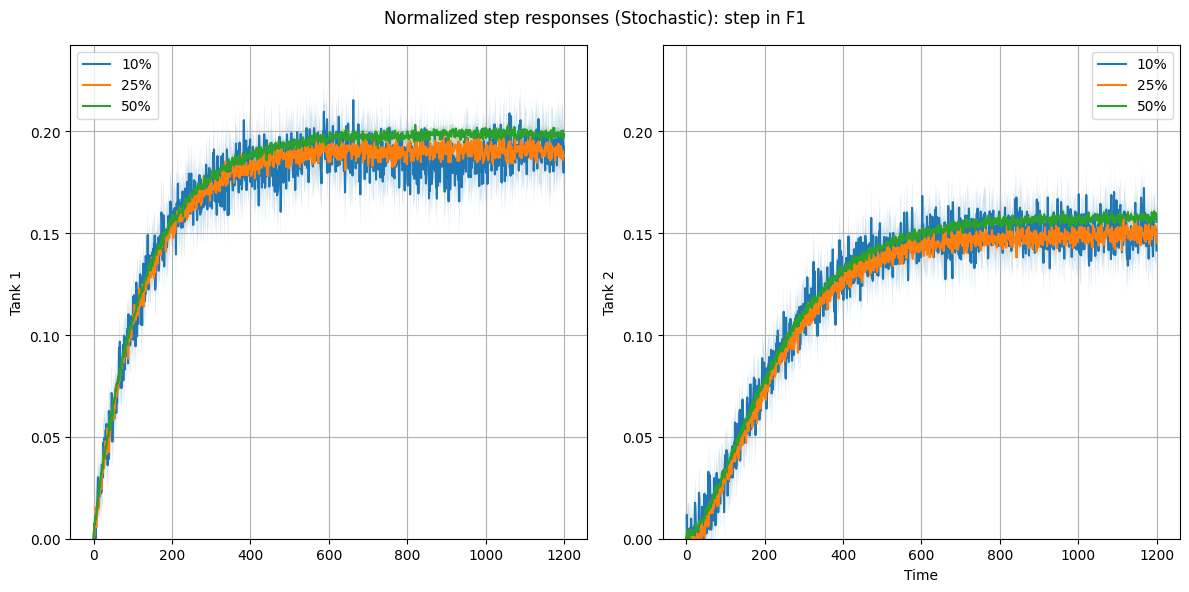

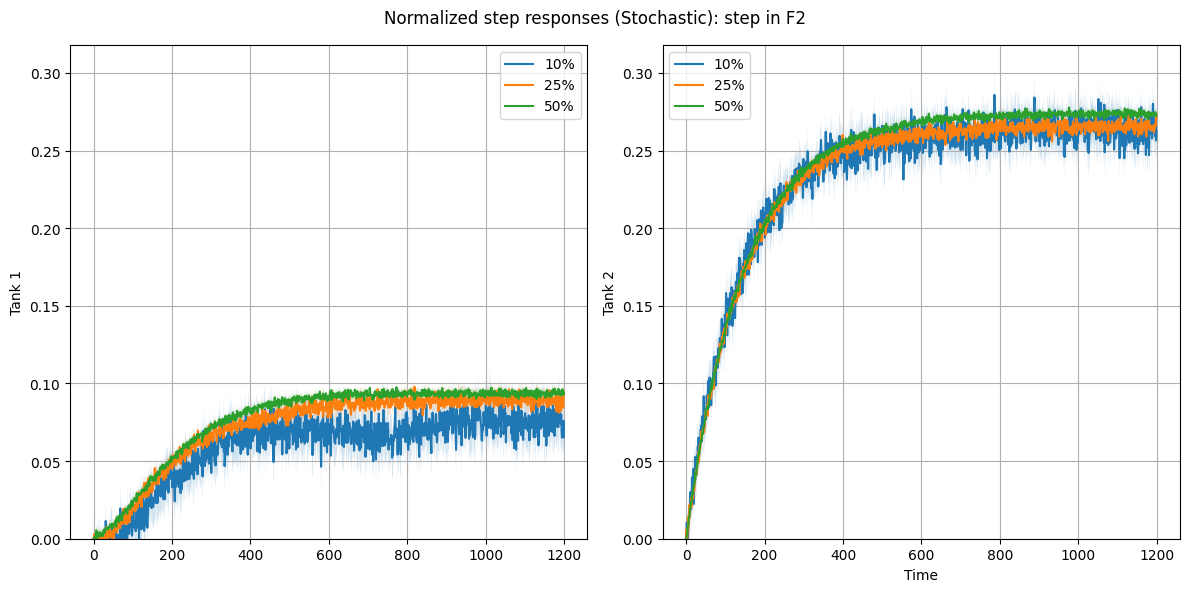

In [221]:
step_labels = ["10%", "25%", "50%"]
tank_labels = ["Tank 1", "Tank 2"]

def mean_and_ci95(x, axis=0):
    # x: (..., n_trials, ..., T) with trials along `axis`
    mean = np.mean(x, axis=axis)
    n = x.shape[axis]
    std = np.std(x, axis=axis, ddof=1)
    sem = std / np.sqrt(n)
    ci = 1.96 * sem
    return mean, mean - ci, mean + ci

time = np.arange(steps_f1_stochastic.shape[3])  # last axis is time

def plot_steps_stochastic_subplots(steps, title):
    # steps shape: (3, n_trials, 2, T)
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

    for i_tank, ax in enumerate(axes):
        for i_step, step_label in enumerate(step_labels):
            y = steps[i_step, :, i_tank, :]          # (n_trials, T)
            m, lo, hi = mean_and_ci95(y, axis=0)     # over trials
            
            start_point = m[0]

            ax.plot(time, (m - start_point) / (200 * step_sizes[i_step] - 200), label=step_label)
            ax.fill_between(time, (lo - start_point) / (200 * step_sizes[i_step] - 200), (hi - start_point) / (200 * step_sizes[i_step] - 200), alpha=0.2)

        ax.set_ylabel(tank_labels[i_tank])
        ax.grid(True)
        ax.legend()

    max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

    axes[0].set_ylim(0, max_ylim)
    axes[1].set_ylim(0, max_ylim)

    axes[-1].set_xlabel("Time")
    fig.suptitle(title)
    fig.tight_layout()

plot_steps_stochastic_subplots(steps_f1_stochastic, "Normalized step responses (Stochastic): step in F1")

plt.savefig("report/figures/problem4/normalized_step_stochastic_f1.pdf", bbox_inches="tight")
plt.show()

plot_steps_stochastic_subplots(steps_f2_stochastic, "Normalized step responses (Stochastic): step in F2")

plt.savefig("report/figures/problem4/normalized_step_stochastic_f2.pdf", bbox_inches="tight")
plt.show()

In [213]:
import numpy as np
from scipy.optimize import least_squares

def fit_mimo_statespace_from_steps(
    steps_f1,
    steps_f2,
    Ts,
    order=2,
    step_index=0,
    step_sizes=None,
    use_all_step_sizes=True,
    normalized=True,
    enforce_stability=False,
    verbose=1,
):
    """
    Joint (MIMO) least-squares fit of a discrete-time state-space model:
        x[k+1] = A x[k] + B u[k]
        y[k]   = C x[k] + D u[k]
    using step response experiments for step in input 1 (F1) and input 2 (F2).

    Parameters
    ----------
    steps_f1, steps_f2 : np.ndarray
        Deterministic: (n_steps, 2, T)
        Stochastic:    (n_steps, n_trials, 2, T)
        These should be *outputs* y for step in F1 / step in F2, respectively.
    Ts : float
        Sampling time [s].
    order : int
        State dimension n.
    step_index : int
        Sample where the step occurs (default 0).
    step_sizes : array-like or None
        Physical step magnitudes for each step-size index (len = n_steps).
        Only needed if normalized=False.
    use_all_step_sizes : bool
        If True, fit using all step-size indices; otherwise fit only index 0.
    normalized : bool
        If True, assumes steps are already normalized by Δu (so Δu=1).
        If False, you must pass step_sizes (Δu for each step-size index).
    enforce_stability : bool
        If True, adds a soft penalty to push eigenvalues of A inside unit circle.
    verbose : int
        least_squares verbosity.

    Returns
    -------
    model : dict
        {"A","B","C","D","Ts","order","residual_norm","success","message"}
        (Plus "tf" if python-control is available.)
    """

    def _to_mean_steps(arr):
        # deterministic: (S, 2, T) -> same
        # stochastic:    (S, R, 2, T) -> mean over trials -> (S, 2, T)
        return arr if arr.ndim == 3 else arr.mean(axis=1)

    Y1 = _to_mean_steps(steps_f1)  # (S, p=2, T)
    Y2 = _to_mean_steps(steps_f2)  # (S, p=2, T)

    S, p, T = Y1.shape
    m = 2  # inputs: [F1, F2]

    idxs = range(S) if use_all_step_sizes else [0]
    if not normalized:
        if step_sizes is None or len(step_sizes) != S:
            raise ValueError("If normalized=False, pass step_sizes with len == n_steps.")

    def simulate(A, B, C, D, U):
        # U: (T, m), returns Yhat: (T, p)
        n = A.shape[0]
        x = np.zeros((n,))
        Yhat = np.zeros((U.shape[0], p))
        for k in range(U.shape[0]):
            u = U[k]
            Yhat[k] = C @ x + D @ u
            x = A @ x + B @ u
        return Yhat

    def pack(A, B, C, D):
        return np.hstack([A.ravel(), B.ravel(), C.ravel(), D.ravel()])

    def unpack(theta):
        n = order
        off = 0
        A = theta[off:off+n*n].reshape(n, n); off += n*n
        B = theta[off:off+n*m].reshape(n, m); off += n*m
        C = theta[off:off+p*n].reshape(p, n); off += p*n
        D = theta[off:off+p*m].reshape(p, m); off += p*m
        return A, B, C, D

    # Build experiments: for each step size s, we have two experiments (step in u1, step in u2)
    experiments = []
    for s in idxs:
        du = 1.0 if normalized else float(step_sizes[s])

        U_f1 = np.zeros((T, m))
        U_f1[step_index:, 0] = du

        U_f2 = np.zeros((T, m))
        U_f2[step_index:, 1] = du

        # Use data from step_index..end (so model aligns with the step)
        y_f1 = Y1[s].T  # (T, p)
        y_f2 = Y2[s].T  # (T, p)

        experiments.append((U_f1, y_f1))
        experiments.append((U_f2, y_f2))

    # Initial guess: small stable-ish A, small gains
    n = order
    A0 = 0.8 * np.eye(n)
    B0 = 0.1 * np.ones((n, m))
    C0 = np.zeros((p, n))
    C0[:min(p, n), :min(p, n)] = np.eye(min(p, n))
    D0 = np.zeros((p, m))

    theta0 = pack(A0, B0, C0, D0)

    def residuals(theta):
        A, B, C, D = unpack(theta)
        res_list = []

        for U, Y in experiments:
            Yhat = simulate(A, B, C, D, U)
            res_list.append((Yhat - Y).ravel())

        res = np.concatenate(res_list)

        if enforce_stability:
            # soft penalty if any eigenvalue magnitude > 0.999
            eig = np.linalg.eigvals(A)
            viol = np.maximum(0.0, np.abs(eig) - 0.999)
            # scale penalty relative to data residual magnitude
            res = np.concatenate([res, 10.0 * viol])

        return res

    sol = least_squares(residuals, theta0, verbose=verbose)

    A, B, C, D = unpack(sol.x)

    model = {
        "A": A, "B": B, "C": C, "D": D,
        "Ts": Ts, "order": order,
        "residual_norm": float(np.linalg.norm(sol.fun)),
        "success": bool(sol.success),
        "message": sol.message,
    }

    # Optional: convert to transfer functions (requires python-control)
    try:
        import control  # pip install control
        sys = control.ss(A, B, C, D, Ts)
        model["ss"] = sys
        # MIMO transfer function matrix
        model["tf"] = control.tf(sys)
    except Exception:
        pass

    return model


In [214]:
# Fit using ALL step sizes, mean over trials if stochastic arrays are passed
model = fit_mimo_statespace_from_steps(
    steps_f1_stochastic, steps_f2_stochastic,
    #use_all_step_sizes=False,
    Ts=2.0, 
    order=2, 
    normalized=False, 
    step_sizes=np.array([20, 50, 100]), 
    enforce_stability=True, 
    verbose=2,
)

A, B, C, D = model["A"], model["B"], model["C"], model["D"]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2621e+07                                    7.59e+07    
       1              2         1.3435e+07      1.92e+07       1.82e+00       1.04e+07    
       2              5         1.3411e+07      2.36e+04       2.28e-01       7.65e+07    
       3              8         1.3260e+07      1.52e+05       3.56e-03       7.88e+06    
       4              9         1.3253e+07      7.22e+03       7.12e-03       4.46e+06    
       5             10         1.3249e+07      3.79e+03       1.42e-02       2.09e+06    
       6             11         1.3247e+07      2.30e+03       2.85e-02       3.41e+06    
       7             12         1.3243e+07      3.11e+03       5.69e-02       1.16e+07    
       8             14         1.3241e+07      2.14e+03       2.85e-02       3.03e+06    
       9             15         1.3240e+07      1.49e+03       5.69e-02       1.46e+07    

In [226]:
A.round(2)

array([[0.99, 0.  ],
       [0.01, 0.99]])

In [227]:
B.round(2)

array([[ 0.,  0.],
       [-0.,  0.]])

In [228]:
C.round(2)

array([[ 0.97, -0.02],
       [-0.04,  1.01]])

In [229]:
D.round(2)

array([[0.99, 0.99],
       [1.25, 1.24]])

In [ ]:
n = 1200

x = np.zeros((1200, 2))
x[0] = mass_steady_state[:2]

u = np.array([200, 220])

for t in range(n - 1):
    x[t + 1] = x[t] + A @ x[t] + B @ u


plt.plot(x[:, 0])
plt.plot(x[:, 1])

plt.show()

TypeError: dot_general requires contracting dimensions to have the same shape, got (4,) and (2,).

In [ ]:
def linearize_system(x_s, u_s, d_s):

    A = jax.jacfwd(
        lambda x: four_tank_system_disturbed(
            x, 
            u_s,
            d_s,
            params,
        )
    )(x_s)

    B = jax.jacfwd(
        lambda u: four_tank_system_disturbed(
            x_s, 
            u,
            d_s,
            params,
        )
    )(u_s)

    G = jax.jacfwd(
        lambda d: four_tank_system_disturbed(
            x_s, 
            u_s,
            d,
            params,
        )
    )(d_s)

    C_y = jax.jacfwd(lambda x: sensor_deterministic(x, params))(x_s)

    D = jnp.zeros((4, 2))
    
    C = jnp.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
    ])

    return A, B, G, C_y, D, C

In [373]:
A, B, C, D = linearize_system(
    jnp.array(mass_steady_state),
    jnp.array([200.0, 200.0]),
    jnp.array([300.0, 300.0]),
)

print(A)
print(B)
print(C)
print(D)

[[-0.00823422  0.          0.01091728  0.        ]
 [ 0.         -0.00736089  0.          0.01012123]
 [ 0.          0.         -0.01091728  0.        ]
 [ 0.          0.          0.         -0.01012123]]
[[0.58 0.  ]
 [0.   0.72]
 [0.   0.28]
 [0.42 0.  ]]
[[0.00263066 0.         0.         0.        ]
 [0.         0.00263066 0.         0.        ]
 [0.         0.         0.00263066 0.        ]
 [0.         0.         0.         0.00263066]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [367]:
def markov_parameters(A, B, C, horizon=25):
    H = np.empty((horizon, C.shape[0], B.shape[1]))

    Ai = np.eye(A.shape[0])
    for i in range(horizon):
        H[i] = C @ Ai @ B
        Ai = Ai @ A

    return H

In [369]:
H = markov_parameters(A, B, C)

<StemContainer object of 3 artists>

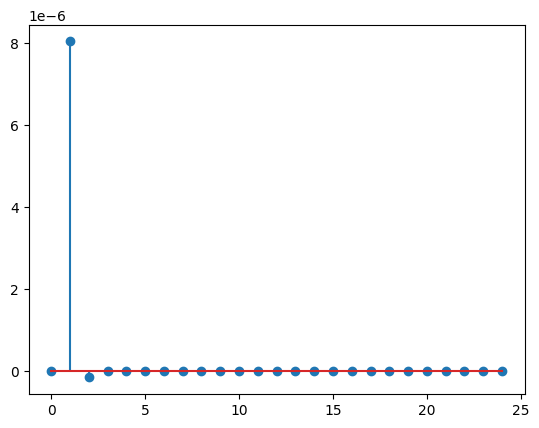

In [370]:
plt.stem(H[:, 0, 1])

In [379]:
import control

sys = control.ss(A, B, C[:2, :], D[:2, :])
G = control.ss2tf(sys)

print(G)

<TransferFunction>: sys[16]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']

Input 1 to output 1:

    0.001526 s^3 + 4.333e-05 s^2 + 4.049e-07 s + 1.241e-09
  -----------------------------------------------------------
  s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998e-06 s + 6.697e-09

Input 1 to output 2:

            1.118e-05 s^2 + 2.142e-07 s + 1.005e-09
  -----------------------------------------------------------
  s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998e-06 s + 6.697e-09

Input 2 to output 1:

            8.042e-06 s^2 + 1.406e-07 s + 5.991e-10
  -----------------------------------------------------------
  s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998e-06 s + 6.697e-09

Input 2 to output 2:

    0.001894 s^3 + 5.544e-05 s^2 + 5.374e-07 s + 1.723e-09
  -----------------------------------------------------------
  s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998e-06 s + 6.697e-09


In [ ]:
# time constants
np.linalg.eigvals(A)

array([-0.00823422, -0.00736089, -0.01091728, -0.01012123], dtype=float32)

In [ ]:
# gains
-C @ np.linalg.solve(A, B) + D

Array([[0.1852978 , 0.08945411],
       [0.15010098, 0.25731596],
       [0.        , 0.06746963],
       [0.10916436, 0.        ]], dtype=float32)

In [388]:
bdim = B.shape[1]
block = np.hstack([A, B])
block = np.vstack([
    block,
    np.zeros((bdim, A.shape[1] + bdim))
])

block.round(3)

array([[-0.008,  0.   ,  0.011,  0.   ,  0.58 ,  0.   ],
       [ 0.   , -0.007,  0.   ,  0.01 ,  0.   ,  0.72 ],
       [ 0.   ,  0.   , -0.011,  0.   ,  0.   ,  0.28 ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.42 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [391]:
import scipy

# sampling time
Ts = 1

block_d = scipy.linalg.expm(block)

A_d = block_d[:4, :4]
B_d = block_d[:4, 4:]

print(A_d)
print(B_d)

[[0.99179959 0.         0.01081324 0.        ]
 [0.         0.99266613 0.         0.01003315]
 [0.         0.         0.9891421  0.        ]
 [0.         0.         0.         0.98992982]]
[[0.5776186  0.0015187 ]
 [0.00211311 0.7173566 ]
 [0.         0.27847713]
 [0.41788168 0.        ]]


In [392]:
H_d = markov_parameters(A_d, B_d, C)